# Autoencoder CNN

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


Let's load the MNIST data set.

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Create a *loader* to feed the data batch by batch during training.

In [4]:
batch = 300
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True)

Now, we define the **autoencoder**.

In [5]:
autoencoder = nn.Sequential(
                # Encoder
                nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2), # (32, 14, 14)
                nn.Conv2d(32, 64, 3), # (64, 12, 12)
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2), # (64, 6, 6))
                
                # Low-dimensional representation
                nn.Conv2d(64, 8, 3), # (8, 4, 4) -- latent representation
                nn.PReLU(8),
                nn.BatchNorm2d(8),
                
                # Decoder
                nn.Conv2d(8, 64, 3, padding=2), # (64, 6, 6)
                nn.UpsamplingNearest2d(scale_factor=2), # (64, 12, 12)
                nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
                nn.PReLU(32),
                nn.UpsamplingNearest2d(scale_factor=2), # (32, 28, 28)
                nn.Conv2d(32, 1, 3, padding=1))

autoencoder = autoencoder.type(FloatTensor)

We define the optimization scheme (here **Adam**) for the autoencoder.

In [6]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

Finally, we train the autoencoder.

In [7]:
epochs = 10
data_size = int(mnist.train_labels.size()[0])

for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        images = Variable(images).type(FloatTensor)

        autoencoder.zero_grad()
        reconstructions = autoencoder(images)
        loss = torch.dist(images, reconstructions)
        loss.backward()
        optimizer.step()
        
    print('Epoch %i/%i loss %.4f' % (i + 1, epochs, loss.data[0]))

Epoch 1/10 loss 125.8365
Epoch 2/10 loss 113.3191
Epoch 3/10 loss 111.5222
Epoch 4/10 loss 107.9954
Epoch 5/10 loss 104.4802
Epoch 6/10 loss 103.1601
Epoch 7/10 loss 106.2982
Epoch 8/10 loss 110.8144
Epoch 9/10 loss 101.5613
Epoch 10/10 loss 101.1935


Let's plot some images along their reconstructions.

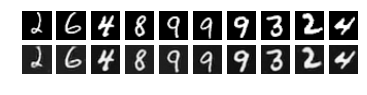

In [8]:
images = images.view(batch, 28, 28).data.cpu().numpy()
reconstructions = reconstructions.view(batch, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(6, 6))
for i in range(10):
    a = fig.add_subplot(10, 10, i + 1)
    b = fig.add_subplot(10, 10, i + 11)
    a.axis('off')
    b.axis('off')
    image = images[i - 1]
    reconstruction = reconstructions[i - 1]
    a.imshow(image, cmap='Greys_r')
    b.imshow(reconstruction, cmap='Greys_r');